# Library

In [26]:
#	Library
import os
import glob
import numpy as np
import bisect
import matplotlib.pyplot as plt

#	astropy
from astropy.io import ascii
from astropy import units as u
from astropy.constants import c
from astropy import constants as const
from astropy.table import Table, vstack, hstack
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value, WMAP9

from scipy.optimize import curve_fit
#	speclite
import speclite.filters
import speclite.redshift


# import numpy as np
# import astropy.io.ascii as ascii
from scipy.interpolate import RegularGridInterpolator

In [2]:
#	plot setting
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

## Function

In [4]:
def tablize_sedinfo(path_sedinfo, models):
	infotbl = Table()
	infotbl['model'] = models
	
	with open(path_sedinfo, 'r') as f:
		for line in f:
			#	Find parameter row
			if line.startswith('PARNAMES: '):
				# print(line)
				headers = line.split()[1:]
				break
		#	Generate empty columns
		for header in headers:
			infotbl[header] = 0.0

		for ll, line in enumerate(f):
			if ll < len(infotbl):
				#	Values
				if line.startswith('SED:'):
					vals = line.split()[2:]
					for hh, header in enumerate(headers):
						infotbl[header][ll] = float(vals[hh])

	return infotbl

def interpolate_seds(infotbl):
	"""
	Interpolates SED data from a list of model files.

	Parameters
	----------
	infotbl : astropy.table.Table
		Table containing information about the models to be interpolated. Must
		contain a column named 'model' with the file paths of the model files.

	Returns
	-------
	interp : scipy.interpolate.RegularGridInterpolator
		Interpolator object that can be used to calculate interpolated flux values
		at any point in the (stretch, color, phase, wavelength) space.
	"""
	#	
	# stretcharr = np.unique(infotbl['stretch'])
	# colorarr = np.unique(infotbl['color'])
	#	Initial info from dummy table
	#	col1: phase
	#	col2: wavelength
	#	col3: flux
	_mdltbl = Table.read(infotbl['model'][0])#, names=['col1', 'col2', 'col3'])
	#	Phase & Wavelength Array
	phasearr = np.unique(_mdltbl['col1'])
	wavelengtharr = np.unique(_mdltbl['col2'])
	#	Array List for Parameters
	arrlist = []
	for kk, key in enumerate(infotbl.keys()):
		if (key!= 'model') & ('INDEX' not in key):
			arrlist.append(np.unique(infotbl[key]))
	arrlist.append(phasearr)
	arrlist.append(wavelengtharr)
	narrlist = [len(arr) for arr in arrlist]

	#	Number of flux elements
	nflux = len(_mdltbl['col3'])
	del _mdltbl
	#	Empyty flux array to reshape and interpolate
	fluxarr = np.zeros(len(infotbl)*nflux)
	#	Read the SED tables and gather the flux arrays
	for mm, model in enumerate(infotbl['model']):
		print(f"[{mm+1}/{len(infotbl)}] {os.path.basename(model)}", end='\r')
		mdltbl = Table.read(model)#, names=['col1', 'col2', 'col3'],)
		flux = mdltbl['col3']
		fluxarr[mm*nflux:(mm+1)*nflux] = flux
		del mdltbl
	print("\nDone!")
	#	Reshape the flux array
	refluxarr = fluxarr.reshape(*narrlist)
	#    Interpolate
	interp = RegularGridInterpolator([arr for arr in arrlist], refluxarr, method='linear')
	return interp

# Initial Setting

In [3]:
lammin = 3750
lammax = 9000
flamunit = u.erg / u.second / u.cm**2 / u.Angstrom
fnuunit = u.erg / u.s / u.cm**2 / u.Hz
lamunit = u.Angstrom

In [9]:
path_model = '../data/PLAsTiCC'

Model
- `col1`: phase [day]
- `col2`: wavelength [AA]
- `col3`: flux [Jy]

# Main

## `SNIa-91bg`

In [77]:
# typ = 'TDE'
# typ = 'SLSN-I'
typ = 'SNIa-91bg'

In [78]:
path_sedinfo = f"{path_model}/{typ}/SIMSED.{typ}/SED.INFO"

#	Original SED files (*.gz)
_models = sorted(glob.glob(f"{path_model}/{typ}/*/*.gz"))
#	Faster SED files (*.fits)
models = sorted(glob.glob(f"{path_model}/{typ}/*/*.fits"))

#	Determine the number of SEDs (fits)
if len(models) < len(_models):
	for _model in _models:
		fitsfile = _model.replace('.gz', '.fits')
		#	If not exist, convert to fits file to speed up the I/O time
		if not os.path.exists(fitsfile):
			print(f"{os.path.basename(_model)} --> {os.path.basename(fitsfile)}")
			ascii.read(_model).write(fitsfile, overwrite=True)
models = sorted(glob.glob(f"{path_model}/{typ}/*/*.fits"))

print(f"Found {len(models)} SEDs for {typ}")

Found 35 SEDs for SNIa-91bg


In [79]:
infotbl = tablize_sedinfo(path_sedinfo, models)
print(infotbl.keys())

for key in infotbl.keys():
	maxval = max(infotbl[key])
	minval = min(infotbl[key])
	print(key, minval, maxval)

['model', 'stretch', 'color']
model ../data/PLAsTiCC/SNIa-91bg/SIMSED.SNIa-91bg/91BG_ST0_C0.SED.fits ../data/PLAsTiCC/SNIa-91bg/SIMSED.SNIa-91bg/91BG_ST6_C4.SED.fits
stretch 0.65 1.25
color 0.0 1.0


In [80]:
interp = interpolate_seds(infotbl)

[35/35] 91BG_ST6_C4.SED.fits
Done!


In [75]:
wavelengtgarr = np.arange(3750, 9000+1, 1)
phase = +10

point = (
    infotbl['stretch'][0],
    infotbl['color'][0],
    phase, # Phase [day]
    wavelengtgarr # Wavelength [AA]
)
#   Interpolated spectrum
iflux = interp(point)

Text(0, 0.5, 'Flux')

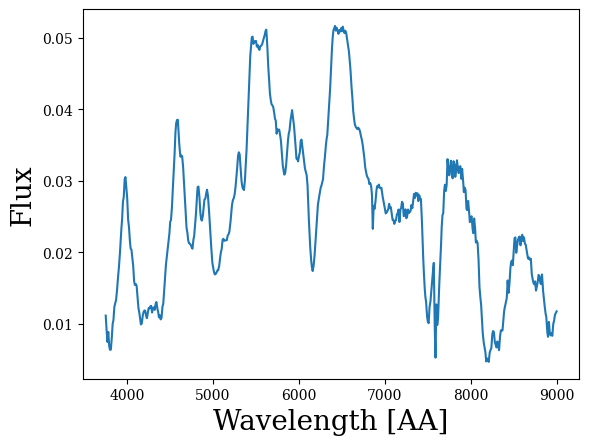

In [76]:
plt.plot(wavelengtgarr, iflux)
plt.xlabel('Wavelength [AA]')
plt.ylabel('Flux')